In [4]:
import pickle
import pandas as pd
import os
import re
from tqdm import tqdm
from scripts.plots_and_evaluation import evaluate_model, plots_and_evaluation, plots_and_evaluation_2

device is:  cuda
device is:  cuda
device is:  cuda


In [5]:
# Example parameters (you may customize these)
df_path = 'datasets\job_melt_complete_data_2024.csv'
remaining_feature_groups_idxs = [2, 4, 5, 6, 8, 9, 10]
feature_prefixes = ['covid', 'indeed', 'inf_VALUE_Bank rate', 'inf_VALUE_Target rate',
                    'cpi_VALUE', 'gdp_VALUE', 'bus', 'job', 'ear', 'emp', 'hou']
plots_dir = "run-2024-08-28-11-12-job"
model_name = 'lag-llama'
datasets = [('job', 'datasets\job_melt_complete_data_2024.csv', 6)]


In [6]:
df = pd.read_csv(df_path)

# Compile final selected features based on remaining indices
feature_groups = [
    [col for col in df.columns if col.startswith(prefix)] 
    for prefix in feature_prefixes
]
final_selected_features = [feature for idx in remaining_feature_groups_idxs for feature in feature_groups[idx]]

# Ensure the results directory exists
os.makedirs(plots_dir, exist_ok=True)
# Evaluate models and save plots
results = []
best_score = float('inf')

FileNotFoundError: [Errno 2] No such file or directory: 'datasets\\job_melt_complete_data_2024.csv'

In [ ]:
for dataset_name, path_to_csv, cl in tqdm(datasets, desc=f"Processing datasets"):
    best_score = float('inf')
    print(f'Processing {dataset_name} with {cl} context_length factor')
    for i in range(1):
        for model_type in ['fine_tuned']:
            result = evaluate_model(model_name, dataset_name, path_to_csv, model_type,
                                    prediction_length=5, # orignal 11
                                    with_external=True, context_length_factor=cl,
                                    selected_features=final_selected_features)

            results.append(result)
            if result.overall_mase < best_score:
                best_score = result.overall_mase
                best_result = result

                # File path for the result pickle file
                result_pickle_path = os.path.join(plots_dir, f'MASE_{result.dataset_name}_best_result.pkl')

                # Check if the file exists and delete it if it does
                if os.path.exists(result_pickle_path):
                    os.remove(result_pickle_path)

                # Save the new best result
                with open(result_pickle_path, 'wb') as f:
                    pickle.dump(best_result, f)

            # Save plots
            plot_obj = plots_and_evaluation(forecasts=result.forecasts, tss=result.ts, title=dataset_name + '_' + model_type)
            save_path = os.path.join(plots_dir, f"{i}_MASE_{result.dataset_name}_{cl}_forecasts.png")
            plot_obj.plot_forcasts_all(save_path=save_path)

            # Create DataFrame
            results_df = pd.DataFrame([result.to_dict() for result in results])


NameError: name 'tqdm' is not defined

In [28]:
result.ts[1]

,0
2001-01,NaN
2001-02,NaN
2001-03,NaN
2001-04,NaN
2001-05,NaN
...,...
2024-01,35645.0
2024-02,36910.0
2024-03,32635.0
2024-04,38765.0


In [50]:
#any additional functions that can be used to help with input files in the time_series_conversion function.



# used for business outlook survey
def convert_to_date(qtr):
    year = int(qtr[:4])
    if qtr[-2:] == 'Q4':
        year += 1
    month = {
        'Q1': '04',
        'Q2': '07',
        'Q3': '10',
        'Q4': '01'
    }[qtr[-2:]]
    return f"{year}-{month}-01"

#The dataset must be correctly formatted/aligned to the monthly format in the base files, and has identify date, category, and value variables for the pivot
# file path: self explantory
# times steps: 20
# var_name: dataset name appended to each variable
# date_variable: the date variable name
# category_variable: categorization of value variables
# value_variables: self explantory
def time_series_conversion(file_path,var_name,date_variable,category_variables,values_variables,time_steps=20):

    print(file_path)

    #file input 
    if file_path == 'datasets/Business_Outlook_Survey-ed-2023-10-01.csv':
        df = pd.read_csv(file_path,skiprows=57)
    else:
        df = pd.read_csv(file_path)

    #specific instructions for certain files
    if file_path == 'datasets/Employment_ByIndustry_2024.csv':
        df = df[df['GEO']=='Canada']
    elif file_path == 'datasets/Business_Outlook_Survey-ed-2023-10-01.csv':
        df[date_variable[0]] = df[date_variable[0]].apply(convert_to_date)
        df = df[df[date_variable[0]]>= '2001-01-01']
        df[date_variable[0]] = pd.to_datetime(df[date_variable[0]])
        df = df.set_index(date_variable[0])
        df = df.shift(1, freq='D').resample('MS').bfill()
        df.reset_index(inplace=True)
    elif file_path == 'datasets/36100434.csv':
        df[date_variable[0]] = pd.to_datetime(df[date_variable[0]], format='%Y-%m').dt.strftime('%Y-%m-%d')
        df = df[(df['North American Industry Classification System (NAICS)'] == 'All industries [T001]') & 
                (df['Seasonal adjustment'] == 'Seasonally adjusted at annual rates') &
                (df['Prices'] == '2017 constant prices') &
                (df[date_variable[0]]>= '2001-01-01')]
    elif file_path == 'datasets/18100004.csv':
        df[date_variable[0]] = pd.to_datetime(df[date_variable[0]], format='%Y-%m').dt.strftime('%Y-%m-%d')
        df = df[(df['Products and product groups'] == 'All-items') & 
                (df['GEO'] == 'Canada') &
                (df[date_variable[0]]>= '2001-01-01')]
    elif file_path == 'datasets/10100139.csv':
        df[date_variable[0]] = pd.to_datetime(df[date_variable[0]])
        df = df[df[date_variable[0]].dt.day == 1]
        df = df[((df['Financial market statistics'] == 'Bank rate' ) | 
                (df['Financial market statistics'] == 'Target rate' )) &
                (df[date_variable[0]]>= '2001-01-01')]
        df[date_variable[0]] = df[date_variable[0]].dt.strftime('%Y-%m-%d')
    elif file_path == 'datasets/covid19-download.csv':
        df[date_variable[0]] = pd.to_datetime(df[date_variable[0]])
        df = df[df['prname'] == "Canada"]
        df = df.groupby(df[date_variable[0]].dt.to_period('M')).agg({
            date_variable[0]: 'first',
            'prname': 'first', 
            'numtotal_last7': 'sum'})
        df.reset_index(drop=True, inplace=True)
        df['date'] = df['date'].dt.to_period('M').dt.to_timestamp()
        df[date_variable[0]] = df[date_variable[0]].dt.strftime('%Y-%m-%d')
    elif file_path == 'datasets/Hiring_Lab_full_country_data_to_2024-03-08.csv':
        df = df[(df['jobcountry']=='Canada') &
                (df['Postings Type']=='Overall Postings')&
                (df['Index Type']=='Indeed Job Postings Index, Feb 01 2020 = 100')]
        df[date_variable[0]] = pd.to_datetime(df['Date'])
        df = df[df[date_variable[0]].dt.is_month_start]
        df[date_variable[0]] = df[date_variable[0]].dt.strftime('%Y-%m-%d')
    elif file_path == 'datasets/17100009.csv':
        df[date_variable[0]] = pd.to_datetime(df[date_variable[0]], format='%Y-%m').dt.strftime('%Y-%m-%d')
        df = df[(df[date_variable[0]]>= '2001-01-01')&(df['GEO'] == 'Canada')]
        df[date_variable[0]] = pd.to_datetime(df[date_variable[0]])
        df = df.set_index(date_variable[0])
        df = df.shift(1, freq='D').resample('MS').bfill()
        df.reset_index(inplace=True)
    
    #filter on pivot variables and then pivot dataframe accordingly
    df = df[date_variable + category_variables + values_variables]
    if len(category_variables)>0:
        df = df.pivot(index=date_variable,columns = category_variables,values=values_variables).reset_index()
        #... also fix multi index issues
        for c in category_variables:
            df = df.reset_index(drop=True)
        df.columns = ['_'.join(map(str, col)).strip() for col in df.columns.values]
        df.rename(columns= {df.columns[0]:'REF_DATE'},inplace=True)
    df[df.columns[0]]=pd.to_datetime(df[df.columns[0]]).dt.strftime('%Y-%m-%d')
    df.set_index(df.columns[0], inplace=True)

    #fix add timestep columns
    for col in df:
        for lag in range(1, time_steps + 1):
            df[f'{col}_t-{lag}'] = df[col].shift(lag)

    #add id to columns so that they don't overlap with other files
    df.columns = var_name + df.columns

    return df

In [61]:
# Define a function to extract timesteps and handle columns without timesteps
def extract_timestep(column_name):

    timestep_pattern = re.compile(r"_t-(\d+)$")

    match = timestep_pattern.search(column_name)
    if match:
        # Return the timestep as an integer to sort numerically
        return int(match.group(1))
    else:
        # Assign a default value that sorts before the timesteps (e.g., -1)
        return -1

def data_creation(time_steps):

    #base data
    df_job = time_series_conversion('datasets/JobVacancies_ByIndustry_2024.csv','job_',['REF_DATE'],['North American Industry Classification System (NAICS)','Statistics'],['VALUE'],time_steps)
    df_ear = time_series_conversion('datasets/Earnings_ByIndustry_2024.csv','ear_',['REF_DATE'],['North American Industry Classification System (NAICS)'],['VALUE'],time_steps)
    df_emp = time_series_conversion('datasets/Employment_ByIndustry_2024.csv','emp_',['REF_DATE'],['North American Industry Classification System (NAICS)'],['VALUE'],time_steps)
    df_hou = time_series_conversion('datasets/Hours_ByIndustry_2024.csv','hou_',['REF_DATE'],['North American Industry Classification System (NAICS)'],['VALUE',],time_steps)
    df_bus = time_series_conversion('datasets/Business_Outlook_Survey-ed-2023-10-01.csv','bus_',['date'],[],['EMPLOY','COSTS','OUTPUTS'],time_steps)
    df_gdp = time_series_conversion('datasets/36100434.csv','gdp_',['REF_DATE'],[],['VALUE'],time_steps)
    df_cpi = time_series_conversion('datasets/18100004.csv','cpi_',['REF_DATE'],[],['VALUE'],time_steps)
    df_inf = time_series_conversion('datasets/10100139.csv','inf_',['REF_DATE'],['Financial market statistics'],['VALUE'],time_steps)
    df_pop = time_series_conversion('datasets/17100009.csv','pop_',['REF_DATE'],['GEO'],['VALUE'],time_steps)
    df_covid = time_series_conversion('datasets/covid19-download.csv','covid_',['date'],['prname'],['numtotal_last7'],time_steps)
    df_indeed = time_series_conversion('datasets/Hiring_Lab_full_country_data_to_2024-03-08.csv','indeed_',['Date'],['Sector'],['Non-seasonally adjusted percentage'],time_steps)
    output_var_size = sum([len(dfs.columns) for dfs in [df_job, df_ear, df_emp, df_hou]])/(time_steps+1)
    input_var_size = sum([len(dfs.columns) for dfs in [df_pop,df_indeed,df_covid,df_inf,df_cpi,df_gdp,df_bus,df_job, df_ear, df_emp, df_hou]])/(time_steps+1)
    df = df_pop
    for df1 in [df_covid,df_indeed,df_inf,df_cpi,df_gdp,df_bus,df_job,df_ear,df_emp,df_hou]:
        df = pd.merge(df,df1,how = 'outer',left_index=True,right_index=True)

    # Sort the DataFrame's columns by the extracted timestep
    sorted_columns = sorted(df.columns, key=extract_timestep,reverse=True)
    df = df[sorted_columns]
    df = df[(df.index >= '2000-02-01') & (df.index <= '2024-12-01')]
    df.fillna(0,inplace=True)
    
    return df_job,df_ear,df_emp,df_hou,df,input_var_size,output_var_size

def convert_to_csv(df,input_var_size):
    labour_ind = ['job_','ear_','emp_','hou_']
    for ind in labour_ind:
        if ind == 'job_':
            df_col = [col for col in df.columns if col.startswith(ind) and col.endswith('cies')]
            other_col = [col for col in df.columns if not(col.startswith(ind)) or (col.startswith(ind) and not(col.endswith('cies')))]
        else:
            df_col = [col for col in df.columns if col.startswith(ind)]
            other_col = [col for col in df.columns if not(col.startswith(ind))]
        df[other_col] = df[other_col].shift(1)
        df.fillna(0,inplace=True)
        melt_df = df.iloc[:,-int(input_var_size):][df_col]
        melt_df = melt_df.reset_index()
        melt_df = pd.melt(melt_df, id_vars=['index'], var_name='feature_name', value_name='feature_value')
        melt_df = melt_df.set_index('index')
        melt_df.head()
        df_gluton = pd.merge(melt_df,df,how = 'left',left_index=True,right_index=True)
        df_gluton.to_csv(f'datasets/{ind}melt_complete_data_2024.csv')

In [62]:
time_steps = 0
df_job,df_ear,df_emp,df_hou,df,input_var_size,output_var_size = data_creation(time_steps)

datasets/JobVacancies_ByIndustry_2024.csv
datasets/Earnings_ByIndustry_2024.csv
datasets/Employment_ByIndustry_2024.csv
datasets/Hours_ByIndustry_2024.csv
datasets/Business_Outlook_Survey-ed-2023-10-01.csv
datasets/36100434.csv


C:\Users\Abdul-AzizAlNajjar\AppData\Local\Temp\ipykernel_45944\2926598367.py:33: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


datasets/18100004.csv


C:\Users\Abdul-AzizAlNajjar\AppData\Local\Temp\ipykernel_45944\2926598367.py:33: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


datasets/10100139.csv
datasets/17100009.csv
datasets/covid19-download.csv
datasets/Hiring_Lab_full_country_data_to_2024-03-08.csv


In [64]:
convert_to_csv(df,input_var_size)

Plotting model datasets: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


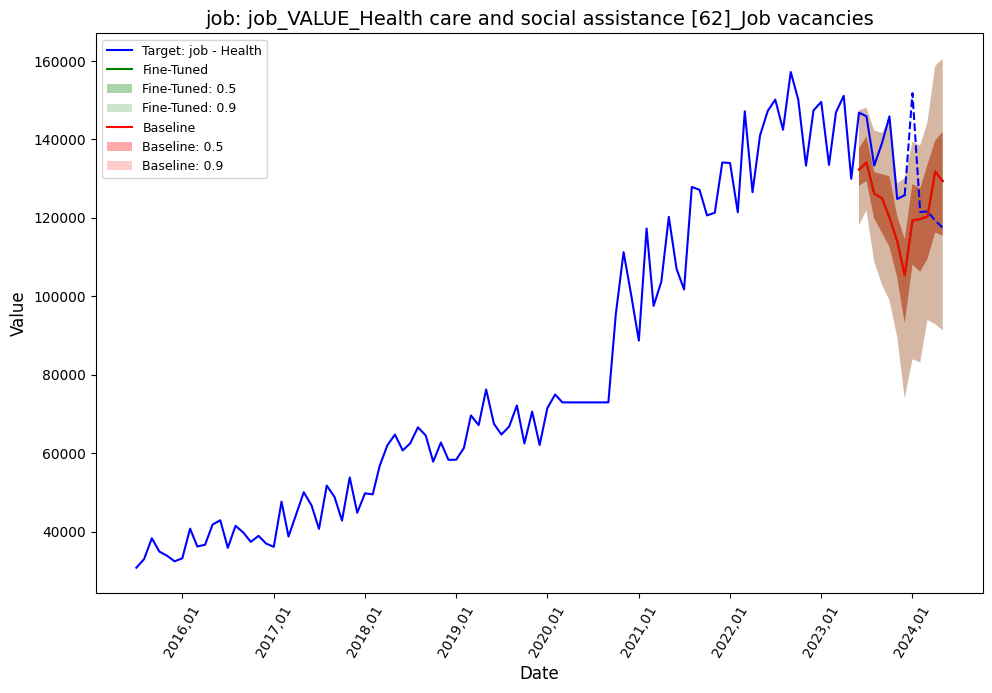

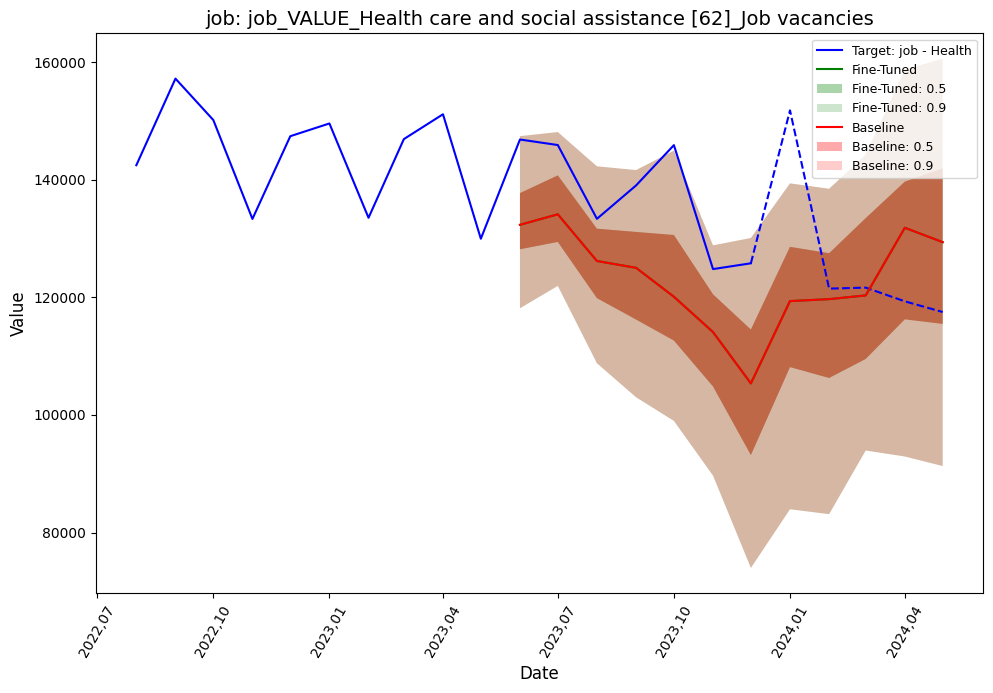

In [8]:
import pickle
import pandas as pd
import os
import re
from tqdm import tqdm
from scripts.plots_and_evaluation import evaluate_model, plots_and_evaluation, plots_and_evaluation_2

# plots_dir_ = 'Final_run-EEHJ'
plots_dir = r'run-2024-08-28-11-12-job'
results = []
datasets = [('job','job_melt_complete_data', 6)]
# datasets = [('emp', 'emp_melt_complete_data_2024.csv', 6), ('earn', 'ear_melt_complete_data_2024.csv', 6), ('hours', 'hou_melt_complete_data_2024.csv', 6), ('job', 'job_melt_complete_data_2024.csv', 5.2)]
for dataset_name, path_to_csv, cl in tqdm(datasets, desc=f"Plotting model datasets"):
    # Specify the path to the pickle file
    pickle_file_path_fine_tuned = f'{plots_dir}\\fine_tuned_{dataset_name}_best_result.pkl'
    pickle_file_path_baseline = f'{plots_dir}\\baseline_{dataset_name}_best_result.pkl'

    # pickle_file_path = r'Final_run-EEHJ\final_earn_best_result.pkl'

    # Load the best result from the pickle file
    with open(pickle_file_path_fine_tuned, 'rb') as f:
        loaded_best_result_fine_tuned = pickle.load(f)
    with open(pickle_file_path_baseline, 'rb') as f:
        loaded_best_result_baseline = pickle.load(f)
    # plot_only = None
    # plot_only = 'Total, all industries' if dataset_name == 'job' else 'Industrial aggregate exclu'
    plot_only = 'Health'
    
    plot_obj = plots_and_evaluation_2(forecasts= loaded_best_result_fine_tuned.forecasts, tss=loaded_best_result_fine_tuned.ts, forecasts_2=loaded_best_result_baseline.forecasts,
                                      tss_2=loaded_best_result_baseline.ts, title = loaded_best_result_fine_tuned.dataset_name, plot_only=plot_only)
    save_path = os.path.join(plots_dir, f"{loaded_best_result_fine_tuned.dataset_name}_both_forecasts_final.png")
    plot_obj.plot_forcasts_all(Dataset_name = loaded_best_result_fine_tuned.dataset_name, save_path=save_path, zoom_to_predicted= False)
    # agg_metrics, ts_metrics, agg_metrics_2, ts_metrics_2 = plot_obj.evaluate()
    plot_obj.plot_forcasts_all(Dataset_name = loaded_best_result_fine_tuned.dataset_name, save_path=save_path, zoom_to_predicted= True)
    # agg_metrics, ts_metrics, agg_metrics_2, ts_metrics_2 = plot_obj.evaluate()

    if 'job' in dataset_name:
        column= dataset_name[:3]+'_VALUE_'+'Total, all industries'+'_Job vacancies'
    else: 
        column = dataset_name[:3]+'_VALUE_'+'Industrial aggregate excluding unclassified businesses [11-91N]'

    # Finetuned_all_industries_mape = ts_metrics[ts_metrics['item_id'] == column]['MAPE'].item()
    # baseline_all_industries_mape = ts_metrics_2[ts_metrics_2['item_id'] == column]['MAPE'].item()  

    # # Store the results
    # results.append({
    #     'Dataset': dataset_name,
    #     'Finetuned MAPE': agg_metrics['MAPE'],
    #     'Baseline MAPE': agg_metrics_2['MAPE'],
    #     'Finetuned MASE': agg_metrics['MASE'],
    #     'Baseline MASE': agg_metrics_2['MASE'],
    #     'Finetuned All Industries MAPE': Finetuned_all_industries_mape,
    #     'Baseline All Industries MAPE': baseline_all_industries_mape
    # })
    
# Convert results to a DataFrame
# df_results = pd.DataFrame(results)

# # Save to CSV
# csv_file_path = os.path.join(plots_dir, 'baseline_finetuned_comparison.csv')
# df_results.to_csv(csv_file_path, index=False)   


In [14]:
loaded_best_result_fine_tuned.ts[1].to_timestamp()[loaded_best_result_fine_tuned.ts[1].index >= '2024-01-01']

,0
2024-01-01,35645.0
2024-02-01,36910.0
2024-03-01,32635.0
2024-04-01,38765.0
2024-05-01,29865.0
